In [1]:
import pandas as pd
df = pd.read_csv("./penguins_train.csv")


In [2]:
df.drop("Sex", axis=1, inplace=True)

In [3]:
df.head()

,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Species
0,Biscoe,Yes,38.8,17.2,180.0,3800.0,9.63954,-25.29856,Adelie Penguin (Pygoscelis adeliae)
1,Torgersen,Yes,41.1,18.6,189.0,3325.0,9.32277,-26.09989,Adelie Penguin (Pygoscelis adeliae)
2,Biscoe,Yes,39.0,17.5,186.0,3550.0,8.57199,-26.07188,Adelie Penguin (Pygoscelis adeliae)
3,Dream,No,39.7,17.9,193.0,4250.0,9.25769,-25.88798,Adelie Penguin (Pygoscelis adeliae)
4,Biscoe,Yes,47.5,14.2,209.0,4600.0,8.39299,-26.78733,Gentoo penguin (Pygoscelis papua)


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df["Island"] = encoder.fit_transform(df["Island"])
df["Clutch Completion"] = encoder.fit_transform(df["Clutch Completion"])

df["Species"] = encoder.fit_transform(df["Species"])

In [5]:
for column in df.columns:
    df[column] = df[column].astype(float)
    df[column].fillna(df[column].mean(), inplace=True)

In [6]:
X = df.drop(["Species"], axis=1).values
y = df["Species"].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [8]:
from sklearn.base import clone
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [9]:
# One-vs-One (OvO) classifier
class OneVsOneClassifierManual:
    def __init__(self, base_classifier):
        self.base_classifier = base_classifier
        self.classifiers = []
        self.classes_pair = []
        
    def fit(self, X, y):
        unique_classes = np.unique(y)
        for i in range(len(unique_classes)):
            for j in range(i+1, len(unique_classes)):
                class_A = unique_classes[i]
                class_B = unique_classes[j]
                X_pair = X[(y == class_A) | (y == class_B)]
                y_pair = y[(y == class_A) | (y == class_B)]
                y_pair = np.where(y_pair == class_A, 1, -1)
                classifier = clone(self.base_classifier)
                classifier.fit(X_pair, y_pair)
                self.classifiers.append(classifier)
                self.classes_pair.append((class_A, class_B))
                
    def predict(self, X):
        predictions = []
        for x in X:
            votes = Counter()
            for classifier, (class_A, class_B) in zip(self.classifiers, self.classes_pair):
                pred = classifier.predict([x])
                if pred == 1:
                    votes[class_A] = votes.get(class_A, 0) + 1
                else:
                    votes[class_B] = votes.get(class_B, 0) + 1
            most_voted = votes.most_common(1)[0][0]
            predictions.append(most_voted)
        return np.array(predictions)
    
    

In [10]:
# Initialize the base classifier (Linear SVM)
base_classifier = SVC(kernel='linear')

In [11]:
# Create and train OvA classifier
ova_classifier_manual = OneVsOneClassifierManual(base_classifier)
ova_classifier_manual.fit(X_train, y_train)

In [12]:
y_pred = ova_classifier_manual.predict(X_test)
y_true = y_test

In [13]:
decoded_y_pred = encoder.inverse_transform(y_pred.astype(int))
decoded_y_true = encoder.inverse_transform(y_true.astype(int))

# save the true and predicted values in a csv file
df = pd.DataFrame({'True Values': decoded_y_true, 'Predicted Values': decoded_y_pred})
df.to_csv('one_vs_one.csv', index=False)

print(decoded_y_pred)

['Gentoo penguin (Pygoscelis papua)' 'Gentoo penguin (Pygoscelis papua)'
 'Gentoo penguin (Pygoscelis papua)' 'Gentoo penguin (Pygoscelis papua)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Gentoo penguin (Pygoscelis papua)' 'Adelie Penguin (Pygoscelis adeliae)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Gentoo penguin (Pygoscelis papua)' 'Adelie Penguin (Pygoscelis adeliae)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Adelie Penguin (Pygoscelis adeliae)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Gentoo penguin (Pygoscelis papua)' 'Adelie Penguin (Pygoscelis adeliae)'
 'Gentoo penguin (Pygoscelis papua)' 'Adelie Pe

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_true, y_pred, average="micro")
print("Precision:", precision)

recall = recall_score(y_true, y_pred, average="micro")
print("Recall:", recall)

f1 = f1_score(y_true, y_pred, average="micro")
print("F1-Score:", f1)


Accuracy: 0.9636363636363636
Precision: 0.9636363636363636
Recall: 0.9636363636363636
F1-Score: 0.9636363636363636


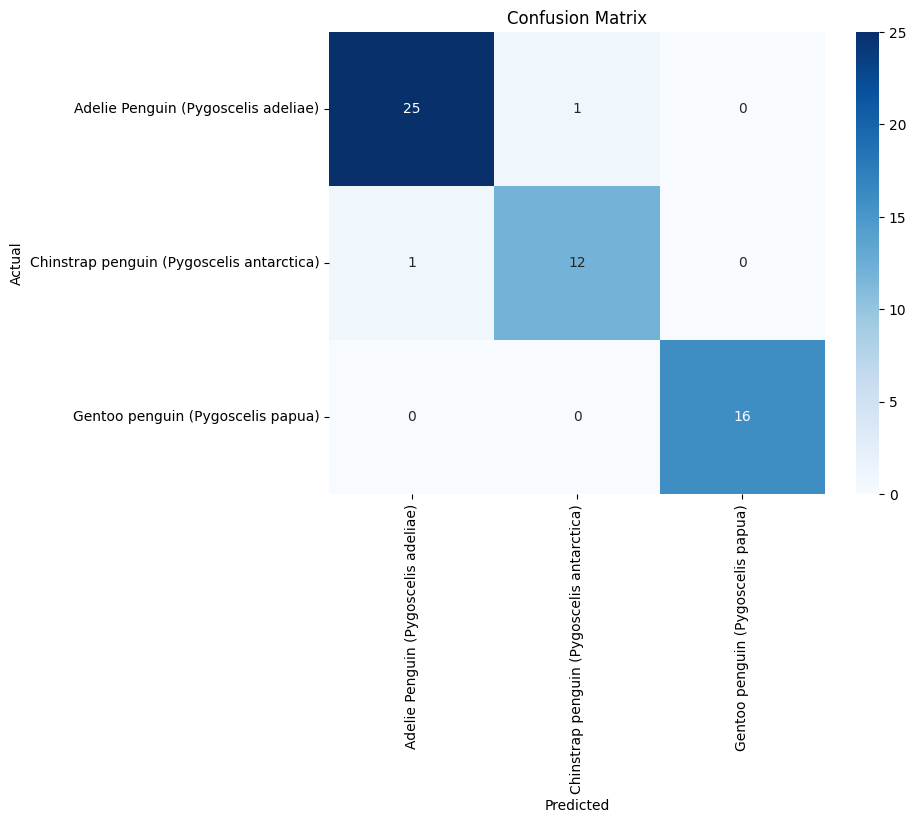

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Create a DataFrame for better visualization
confusion_df = pd.DataFrame(confusion_mat, index=encoder.classes_, columns=encoder.classes_)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()